In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.base import clone
from menelaus.concept_drift import LinearFourRates, ADWINAccuracy, DDM, EDDM, STEPD, MD3

In [3]:
df=pd.read_csv('df2.csv')

In [4]:
df.head()

,Unnamed: 0,category,rating,label,count_punct,Number of Words,exclamation_mark,first_person_noun
0,0,1,5.0,0,5,12,1,1
1,1,1,5.0,0,3,16,0,1
2,2,1,5.0,0,2,14,0,2
3,3,1,1.0,0,2,17,0,1
4,4,1,5.0,0,2,18,0,0


In [5]:
df=df.drop(['Unnamed: 0'], axis=1)

In [6]:
df=df.iloc[:,[0,1,3,4,5,6,2]]

In [7]:
df.head()

,category,rating,count_punct,Number of Words,exclamation_mark,first_person_noun,label
0,1,5.0,5,12,1,1,0
1,1,5.0,3,16,0,1,0
2,1,5.0,2,14,0,2,0
3,1,1.0,2,17,0,1,0
4,1,5.0,2,18,0,0,0


In [8]:
training_size = 30324

In [16]:
X_train = df.loc[0:training_size, ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
y_train = df.loc[0:training_size, "label"]
X_test = df.loc[training_size:len(df), ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
y_true = df.loc[training_size:len(df), "label"]

In [17]:
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB()

In [11]:
acc_orig = np.cumsum(clf.predict(X_test) == y_true)
acc_orig = acc_orig / np.arange(1, 1 + len(acc_orig))
print(acc_orig)

30324    1.000000
30325    1.000000
30326    1.000000
30327    1.000000
30328    1.000000
           ...   
40427    0.576603
40428    0.576645
40429    0.576687
40430    0.576729
40431    0.576771
Name: label, Length: 10108, dtype: float64


### ADWIN

In [12]:
adwin = ADWINAccuracy()

# Set up DF to record results.
status = pd.DataFrame(
    columns=["index", "y_true", "y_pred", "adwin mean", "drift_detected"]
)
rec_list = []

In [13]:
for i in range(training_size, len(df)):

    X_test = df.loc[[i], ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
    y_pred = int(clf.predict(X_test))
    y_true = int(df.loc[[i], "label"])

    adwin.update(y_true, y_pred)
    status.loc[i] = [
        i, y_true, y_pred, adwin.mean(), adwin.drift_state,
    ]

    # If drift is detected, examine the window and retrain.
    if adwin.drift_state == "drift":
        retrain_start = adwin.retraining_recs[0] + training_size
        retrain_end = adwin.retraining_recs[1] + training_size
        rec_list.append([retrain_start, retrain_end])

        # The retraining recommendations produced here correspond to the samples
        # which belong to ADWIN's new, smaller window, after drift is detected.
        # If retraining is not desired, omit the next four lines.
        X_train = df.loc[retrain_start:retrain_end, ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
        y_train = df.loc[retrain_start:retrain_end, "label"]
        clf = GaussianNB()
        clf.fit(X_train, y_train)

status['original_accuracy'] = acc_orig
status['accuracy'] = np.cumsum(status.y_true == status.y_pred)
status['accuracy'] = status['accuracy'] / np.cumsum(np.repeat(1, status.shape[0]))

In [14]:
print(status)

         index  y_true  y_pred  adwin mean drift_detected  original_accuracy  \
30324  30324.0     0.0     0.0    1.000000            NaN           1.000000   
30325  30325.0     0.0     0.0    1.000000            NaN           1.000000   
30326  30326.0     0.0     0.0    1.000000            NaN           1.000000   
30327  30327.0     0.0     0.0    1.000000            NaN           1.000000   
30328  30328.0     0.0     0.0    1.000000            NaN           1.000000   
...        ...     ...     ...         ...            ...                ...   
40427  40427.0     1.0     0.0    0.493492            NaN           0.576603   
40428  40428.0     0.0     0.0    0.493630            NaN           0.576645   
40429  40429.0     1.0     0.0    0.493496            NaN           0.576687   
40430  40430.0     0.0     0.0    0.493633            NaN           0.576729   
40431  40431.0     1.0     0.0    0.493499            NaN           0.576771   

       accuracy  
30324  1.000000  
303

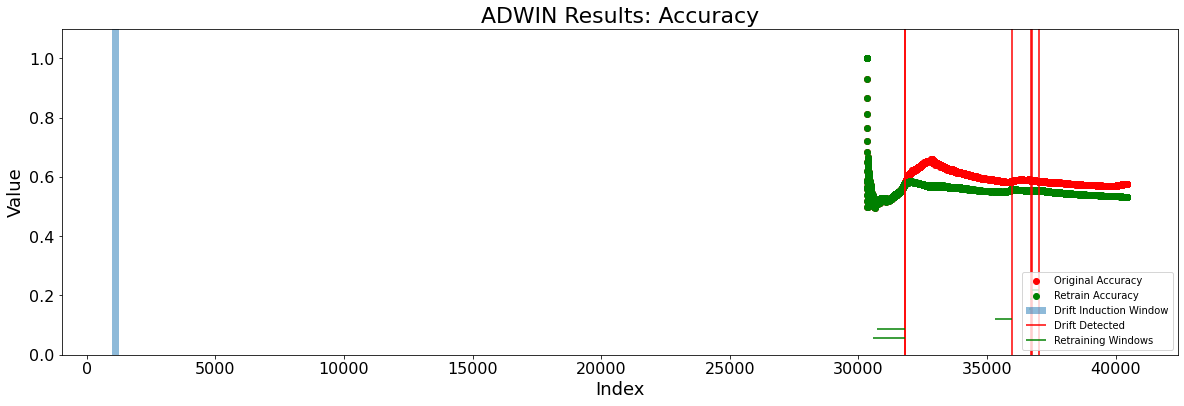

In [51]:
plt.figure(figsize=(20, 6))
plt.scatter("index", "original_accuracy", data=status, label="Original Accuracy", color='red')
plt.scatter("index", "accuracy", data=status, label="Retrain Accuracy", color='green')
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("ADWIN Results: Accuracy", fontsize=22)
plt.ylabel("Value", fontsize=18)
plt.xlabel("Index", fontsize=18)
ylims = [0, 1.1]
plt.ylim(ylims)

plt.axvspan(1000, 1250, alpha=0.5, label="Drift Induction Window")

# Draw red lines that indicate where drift was detected
plt.vlines(
    x=status.loc[status["drift_detected"] == "drift"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Drift Detected",
    color="red",
)

# Create a list of lines that indicate the retraining windows.
# Space them evenly, vertically.
rec_list = pd.DataFrame(rec_list)
rec_list["y_val"] = np.linspace(
    start=0.05 * (ylims[1] - ylims[0]) + ylims[0],
    stop=0.2 * ylims[1],
    num=len(rec_list),
)

# Draw green lines that indicate where retraining occurred
plt.hlines(
    y=rec_list["y_val"],
    xmin=rec_list[0],
    xmax=rec_list[1],
    color="green",
    label="Retraining Windows",
)

plt.legend(loc='lower right')
plt.show()
# plt.savefig("example_ADWINAccuracy.png")


### DDM

In [18]:
np.random.seed(123)
# setup classifier: train on first training_size rows
X_train = df.loc[0:training_size, ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
y_train = df.loc[0:training_size, "label"]
X_test = df.loc[training_size:len(df),  ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
y_true = df.loc[training_size:len(df), "label"]

clf = GaussianNB()
clf.fit(X_train, y_train)

acc_orig = np.cumsum(clf.predict(X_test) == y_true)
acc_orig = acc_orig / np.arange(1, 1 + len(acc_orig))
print(acc_orig)

30324    1.000000
30325    1.000000
30326    1.000000
30327    1.000000
30328    1.000000
           ...   
40427    0.576603
40428    0.576645
40429    0.576687
40430    0.576729
40431    0.576771
Name: label, Length: 10108, dtype: float64


In [19]:
ddm = DDM(n_threshold=100, warning_scale=7, drift_scale=10)

# setup DF to store results
status = pd.DataFrame(columns=["index", "y_true", "y_pred", "drift_detected"])
rec_list = []

In [20]:
for i in range(training_size, len(df)):

    X_test = df.loc[[i], ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
    y_pred = int(clf.predict(X_test))
    y_true = int(df.loc[[i], "label"])

    ddm.update(y_true, y_pred)
    status.loc[i] = [i, y_true, y_pred, ddm.drift_state]

    # If drift is detected, examine the window and retrain.
    if ddm.drift_state == "drift":
        print("Detected at"+str(i))
        retrain_start = ddm.retraining_recs[0] +training_size
        retrain_end = ddm.retraining_recs[1] + training_size
        if (
            retrain_start == retrain_end
        ):  # minimum retraining window in case of sudden drift
            retrain_start = max(0, retrain_start - 300)
        rec_list.append([retrain_start, retrain_end])

        # If retraining is not desired, omit the next four lines.
        X_train = df.loc[retrain_start:retrain_end, ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
        y_train = df.loc[retrain_start:retrain_end, "label"]
        clf = GaussianNB()
        clf.fit(X_train, y_train)

status['original_accuracy'] = acc_orig
status['accuracy'] = np.cumsum(status.y_true == status.y_pred)
status['accuracy'] = status['accuracy'] / np.cumsum(np.repeat(1, status.shape[0]))

Detected at34397


In [21]:
print(status)

         index  y_true  y_pred drift_detected  original_accuracy  accuracy
30324  30324.0     0.0     0.0            NaN           1.000000  1.000000
30325  30325.0     0.0     0.0            NaN           1.000000  1.000000
30326  30326.0     0.0     0.0            NaN           1.000000  1.000000
30327  30327.0     0.0     0.0            NaN           1.000000  1.000000
30328  30328.0     0.0     0.0            NaN           1.000000  1.000000
...        ...     ...     ...            ...                ...       ...
40427  40427.0     1.0     1.0            NaN           0.576603  0.565123
40428  40428.0     0.0     1.0            NaN           0.576645  0.565067
40429  40429.0     1.0     1.0            NaN           0.576687  0.565110
40430  40430.0     0.0     1.0            NaN           0.576729  0.565054
40431  40431.0     1.0     1.0            NaN           0.576771  0.565097

[10108 rows x 6 columns]


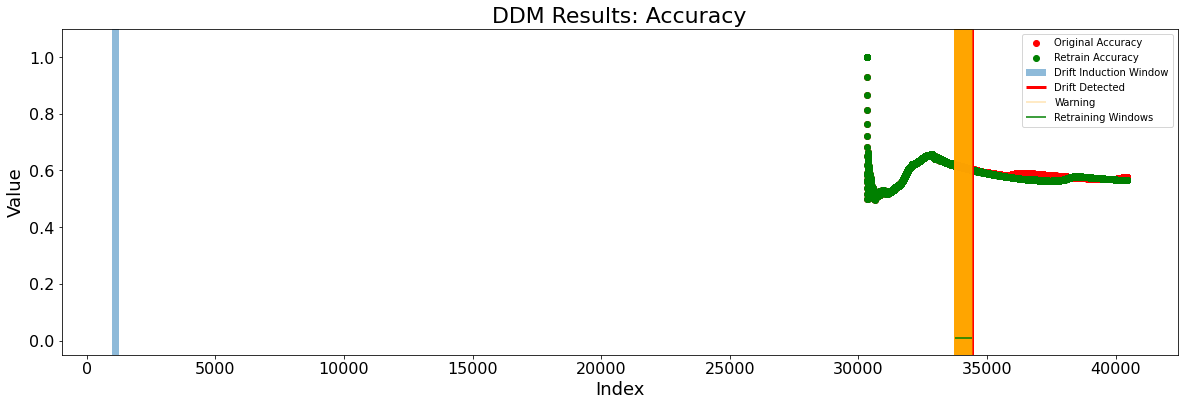

In [56]:
plt.figure(figsize=(20, 6))
plt.scatter("index", "original_accuracy", data=status, label="Original Accuracy", color='red')
plt.scatter("index", "accuracy", data=status, label="Retrain Accuracy", color='green')
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("DDM Results: Accuracy", fontsize=22)
plt.ylabel("Value", fontsize=18)
plt.xlabel("Index", fontsize=18)
ylims = [-0.05, 1.1]
plt.ylim(ylims)

plt.axvspan(1000, 1250, alpha=0.5, label="Drift Induction Window")

# Draw red lines that indicate where drift was detected
plt.vlines(
    x=status.loc[status["drift_detected"] == "drift"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Drift Detected",
    color="red",
    linewidth=3,
)

# Draw orange lines that indicate where warnings of drift were provided
plt.vlines(
    x=status.loc[status["drift_detected"] == "warning"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Warning",
    color="orange",
    alpha=0.3,
)

# Create a list of lines that indicate the retraining windows.
# Space them evenly, vertically.
rec_list = pd.DataFrame(rec_list)
rec_list["y_val"] = np.linspace(
    start=0.05 * (ylims[1] - ylims[0]) + ylims[0],
    stop=0.2 * ylims[1],
    num=len(rec_list),
)

# Draw green lines that indicate where retraining occurred
plt.hlines(
    y=rec_list["y_val"],
    xmin=rec_list[0],
    xmax=rec_list[1],
    color="green",
    label="Retraining Windows",
)

plt.legend()
plt.show()
# plt.savefig("example_DDM.png")

### EDDM

In [23]:
np.random.seed(123)
# setup classifier: train on first 500 rows
X_train = df.loc[0:training_size, ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
y_train = df.loc[0:training_size, "label"]
X_test = df.loc[training_size:len(df), ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
y_true = df.loc[training_size:len(df), "label"]

clf = GaussianNB()
clf.fit(X_train, y_train)

acc_orig = np.cumsum(clf.predict(X_test) == y_true)
acc_orig = acc_orig / np.arange(1, 1 + len(acc_orig))
print(acc_orig)

30324    1.000000
30325    1.000000
30326    1.000000
30327    1.000000
30328    1.000000
           ...   
40427    0.576603
40428    0.576645
40429    0.576687
40430    0.576729
40431    0.576771
Name: label, Length: 10108, dtype: float64


In [24]:
eddm = EDDM(n_threshold=30, warning_thresh=0.7, drift_thresh=0.5)

# setup DF to store results
status = pd.DataFrame(columns=["index", "y_true", "y_pred", "drift_detected"])
rec_list = []


# In[ ]:
# run EDDM and retrain
for i in range(training_size, len(df)):

    X_test = df.loc[[i], ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
    y_pred = int(clf.predict(X_test))
    y_true = int(df.loc[[i], "label"])

    eddm.update(y_true, y_pred)
    status.loc[i] = [i, y_true, y_pred, eddm.drift_state]

    # If drift is detected, examine the window and retrain.
    if eddm.drift_state == "drift":
        retrain_start = eddm.retraining_recs[0] + training_size
        retrain_end = eddm.retraining_recs[1] + training_size
        if (
            retrain_start == retrain_end
        ):  # minimum retraining window in case of sudden drift
            retrain_start = max(0, retrain_start - 300)
        rec_list.append([retrain_start, retrain_end])

        # If retraining is not desired, omit the next four lines.
        X_train = df.loc[retrain_start:retrain_end, ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
        y_train = df.loc[retrain_start:retrain_end, "label"]
        clf = GaussianNB()
        clf.fit(X_train, y_train)

status['original_accuracy'] = acc_orig
status['accuracy'] = np.cumsum(status.y_true == status.y_pred)
status['accuracy'] = status['accuracy'] / np.cumsum(np.repeat(1, status.shape[0]))

In [25]:
print(status)

         index  y_true  y_pred drift_detected  original_accuracy  accuracy
30324  30324.0     0.0     0.0            NaN           1.000000  1.000000
30325  30325.0     0.0     0.0            NaN           1.000000  1.000000
30326  30326.0     0.0     0.0            NaN           1.000000  1.000000
30327  30327.0     0.0     0.0            NaN           1.000000  1.000000
30328  30328.0     0.0     0.0            NaN           1.000000  1.000000
...        ...     ...     ...            ...                ...       ...
40427  40427.0     1.0     0.0        warning           0.576603  0.610649
40428  40428.0     0.0     1.0        warning           0.576645  0.610589
40429  40429.0     1.0     0.0        warning           0.576687  0.610528
40430  40430.0     0.0     0.0        warning           0.576729  0.610567
40431  40431.0     1.0     1.0        warning           0.576771  0.610605

[10108 rows x 6 columns]


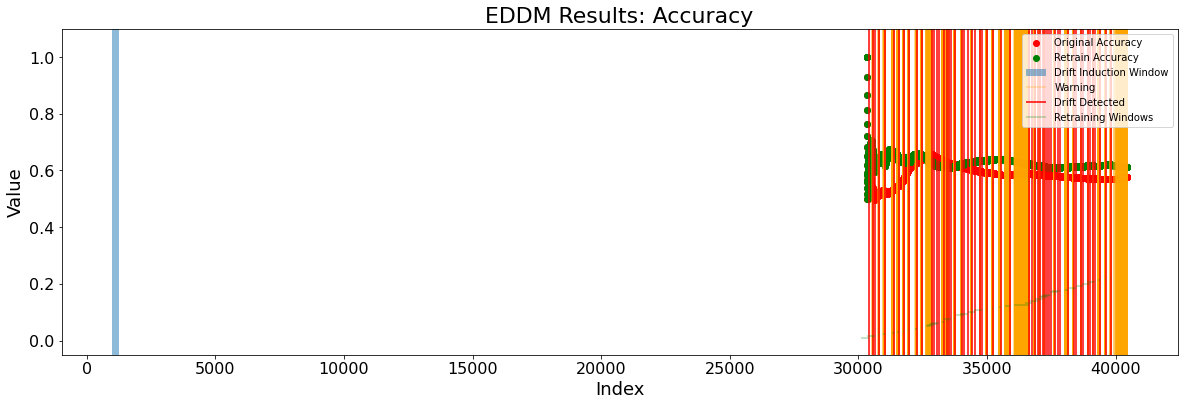

In [60]:
plt.figure(figsize=(20, 6))
plt.scatter("index", "original_accuracy", data=status, label="Original Accuracy", color='red')
plt.scatter("index", "accuracy", data=status, label="Retrain Accuracy", color='green')
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("EDDM Results: Accuracy", fontsize=22)
plt.ylabel("Value", fontsize=18)
plt.xlabel("Index", fontsize=18)
ylims = [-0.05, 1.1]
plt.ylim(ylims)

plt.axvspan(1000, 1250, alpha=0.5, label="Drift Induction Window")

# Draw orange lines that indicate where warnings of drift were provided
plt.vlines(
    x=status.loc[status["drift_detected"] == "warning"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Warning",
    color="orange",
    alpha=0.3,
)

# Draw red lines that indicate where drift was detected
plt.vlines(
    x=status.loc[status["drift_detected"] == "drift"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Drift Detected",
    color="red",
)
# Create a list of lines that indicate the retraining windows.
# Space them evenly, vertically.
rec_list = pd.DataFrame(rec_list)
rec_list["y_val"] = np.linspace(
    start=0.05 * (ylims[1] - ylims[0]) + ylims[0],
    stop=0.2 * ylims[1],
    num=len(rec_list),
)

# Draw green lines that indicate where retraining occurred
plt.hlines(
    y=rec_list["y_val"],
    xmin=rec_list[0],
    xmax=rec_list[1],
    color="green",
    label="Retraining Windows",
    alpha=0.3,
)

plt.legend()
plt.show()
# plt.savefig("example_EDDM.png")